In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
cd "drive/My Drive/Colab Notebooks/ADA_P4/data"

/content/drive/My Drive/Colab Notebooks/ADA_P4/data


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [134]:
df=pd.read_csv('friends_gatherings.csv',parse_dates=['local time_x'])


In [5]:
df.head()

,Unnamed: 0,day_x,local time_x,place_x,country_x,dist home x,dist home y
0,184,Sat,2012-05-05 19:24:41+00:00,Bar,US,161.0,6.0
1,458,Fri,2012-05-04 16:45:44+00:00,Airport,US,18.0,321.0
2,628,Wed,2013-06-18 20:06:35+00:00,Ice Cream Shop,US,159.0,2590.0
3,652,Thu,2012-06-06 23:20:26+00:00,Tech Startup,US,160.0,40.0
4,690,Fri,2012-06-08 17:35:57+00:00,Tech Startup,US,160.0,40.0


In [6]:
df.dtypes

Unnamed: 0                    int64
day_x                        object
local time_x    datetime64[ns, UTC]
place_x                      object
country_x                    object
dist home x                 float64
dist home y                 float64
dtype: object

In [230]:
df['proba dist']=df['dist home x']
df1=df.groupby('dist home x',as_index=False).count()[['dist home x','proba dist']]
#df1=df['proba dist']/df['proba dist'].sum()
df1['proba dist']=df1['proba dist']/df1['proba dist'].sum()
#df['proba dist']=df['dist home x']/df['dist home x'].count()

In [231]:
df1.head()

,dist home x,proba dist
0,0.0,0.026705
1,1.0,0.081007
2,2.0,0.075873
3,3.0,0.068818
4,4.0,0.060047


Text(0.5, 1.0, 'fraction of friends met as a function of the distance from home')

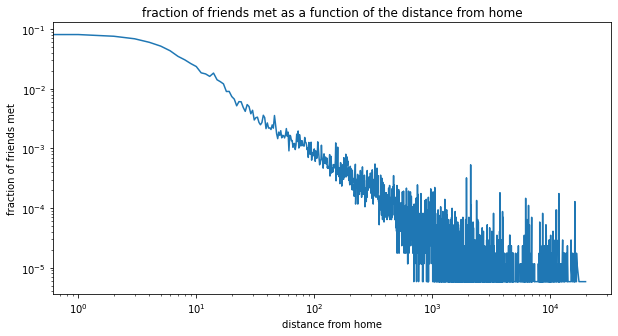

In [234]:
plt.figure(figsize=(10,5))

plt.loglog(df1['dist home x'],df1['proba dist'])
plt.xlabel('distance from home')
plt.ylabel('fraction of friends met')
plt.title('fraction of friends met as a function of the distance from home')

In [53]:
number_restaurant_meetings=df[df['place_x'].str.contains('restaurant',case=False)].shape[0]
number_bar_meetings=df[df['place_x'].str.contains('bar',case=False)].shape[0]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [238]:
df.shape
df1=df.copy()
df1.head()

,Unnamed: 0,day_x,local time_x,place_x,country_x,dist home x,dist home y,proba dist
0,184,Sat,2012-05-05 19:24:41+00:00,Bar,US,161.0,6.0,161.0
1,458,Fri,2012-05-04 16:45:44+00:00,Airport,US,18.0,321.0,18.0
2,628,Wed,2013-06-18 20:06:35+00:00,Ice Cream Shop,US,159.0,2590.0,159.0
3,652,Thu,2012-06-06 23:20:26+00:00,Tech Startup,US,160.0,40.0,160.0
4,690,Fri,2012-06-08 17:35:57+00:00,Tech Startup,US,160.0,40.0,160.0


In [131]:
df1[df1['place_x'].str.contains('college|univeristy',case=False)]['place_x']='college'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [317]:
df1=df.copy()

df1.loc[df1['place_x'].str.contains('restaurant|Burger|pizza|Diner|food|Steakhouse|BBQ|Dessert|Ramen|Ice Cream|Fried|Sandwich|breakfast|snack|taco|hot|soup|wings',case=False),'place_x']='Eat'
df1.loc[df1['place_x'].str.contains('college|University|school|student',case=False),'place_x']='Study'
df1.loc[df1['place_x'].str.contains('coffee|Bar|Nightclub|pub|Lounge|Beer|tea|Nightlife',case=False),'place_x']='Drink'
df1.loc[df1['place_x'].str.contains('multiplex|Movie|Theater|concert|Music|historic|arts|Museum|library|Monument|temple|art',case=False),'place_x']='Culture'
df1.loc[df1['place_x'].str.contains('Home|Residential|Building',case=False),'place_x']='Home'
df1.loc[df1['place_x'].str.contains('station|airport|subway|travel|boat|bus',case=False),'place_x']='Move'
df1.loc[df1['place_x'].str.contains('store|mall|plaza|shop|boutique|market',case=False),'place_x']='Buy stuff'
df1.loc[df1['place_x'].str.contains('work|office|Startup|professional',case=False),'place_x']='Work'
df1.loc[df1['place_x'].str.contains('soccer stadium|Entertainment|Outdoor|beach|park|event|Arcade|resort|hotel|spa|Casino',case=False),'place_x']='Entertainement'
df1.loc[df1['place_x'].str.contains('soccer field|sport|gym|stadium|surf|pool|golf|baseball',case=False),'place_x']='Sport'
#df1.loc[df1['place_x'].str.contains('Neighborhood|road|bakery|church|mosque|hospital|bank|bridge|rest',case=False),'place_x']='Others'

df1.loc[df1['day_x'].str.contains('mon|tue|wed|thu|fri',case=False),'day_x']='Work day'
df1.loc[df1['day_x'].str.contains('sat|sun',case=False),'day_x']='Week end'


df2=df1.loc[df1['place_x'].str.contains('sport|Entertainement|Work|Buy stuff|Move|Home|Culture|Drink|Study|Eat',case=False),:]
df3=df2.groupby(['place_x','day_x'],as_index=False).agg({'country_x':'size'}).sort_values(by='country_x',ascending=False)[['place_x','day_x','country_x']]
#df1.groupby('place_x').count().sort_values(by='day_x',ascending=False).head(50)

KeyError: ignored

In [316]:
df3.head()

,place_x,day_x,country_x
17,Study,Work day,41063
7,Eat,Work day,17308
1,Buy stuff,Work day,10964
6,Eat,Week end,10264
4,Drink,Week end,8004


Text(0.5, 1.0, 'meeting patterns between friends')

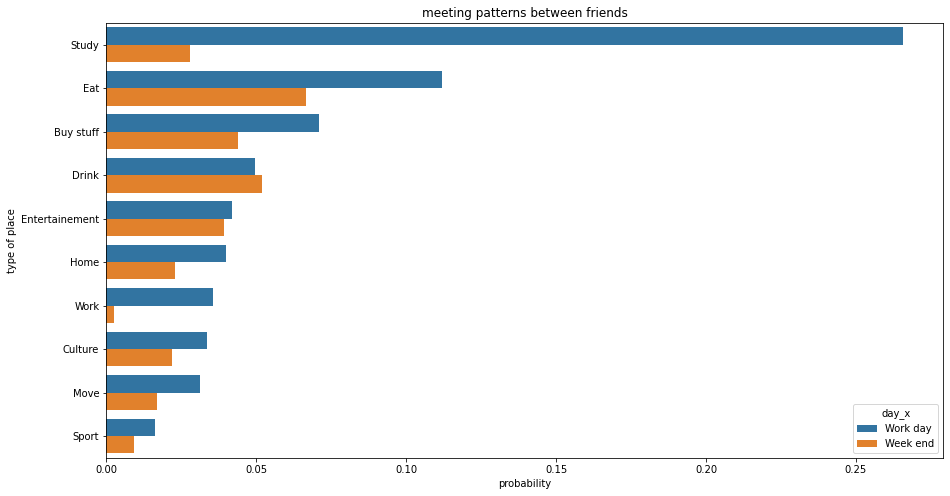

In [251]:
plt.figure(figsize=(15,8))
sns.barplot(x=df3['country_x']/df3['country_x'].sum(),y=df3['place_x'],orient='h',hue=df3['day_x'])
plt.xlabel('probability')
plt.ylabel('type of place')
plt.title('meeting patterns between friends')

In [308]:
def tbd2 (x):
    return sum(x)/max(x)
###### JUSTE DIFF OU DIVISER PAR TOT?????????????????????????????????

In [309]:
df4=df3.copy()
#normalize to have proba/day
df4.loc[df4['day_x'].str.contains('Week|end',case=False),'country_x']=-df4.loc[df4['day_x'].str.contains('Week|end',case=False),'country_x']/2
df4.loc[df4['day_x'].str.contains('Work|day',case=False),'country_x']=df4.loc[df4['day_x'].str.contains('Work|day',case=False),'country_x']/5
df4=df4.groupby('place_x',as_index=False).agg({'country_x':tbd2},axis='columns').sort_values(by='country_x',ascending=False)


,place_x,country_x
9,Work,0.822240
8,Study,0.738512
6,Move,-0.363968
7,Sport,-0.429419
5,Home,-0.437805


Text(0.5, 1.0, 'meeting patterns between friends day week vs week end')

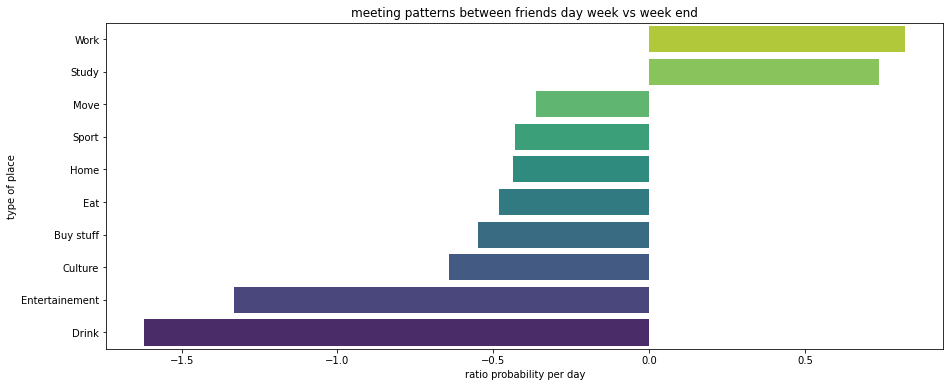

In [312]:
plt.figure(figsize=(15,6))
sns.barplot(x=df4['country_x'],y=df4['place_x'],orient='h', palette='viridis_r')
plt.xlabel('ratio probability per day')
plt.ylabel('type of place')
plt.title('meeting patterns between friends day week vs week end')

In [323]:
df2.loc[:,'evening']=df2['local time_x'].dt.hour>18

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [324]:
df2.head()

,Unnamed: 0,day_x,local time_x,place_x,country_x,dist home x,dist home y,proba dist,evening
0,184,Week end,2012-05-05 19:24:41+00:00,Drink,US,161.0,6.0,161.0,True
1,458,Work day,2012-05-04 16:45:44+00:00,Move,US,18.0,321.0,18.0,False
2,628,Work day,2013-06-18 20:06:35+00:00,Eat,US,159.0,2590.0,159.0,True
3,652,Work day,2012-06-06 23:20:26+00:00,Culture,US,160.0,40.0,160.0,True
4,690,Work day,2012-06-08 17:35:57+00:00,Culture,US,160.0,40.0,160.0,False


In [325]:
df5=df2.groupby('place_x',as_index=False).agg({'evening':'sum','country_x':'size'})

In [331]:
df5['ratio evening']=df5['evening']/df5['country_x']
df5=df5.sort_values(by='ratio evening',ascending=False)

Text(0.5, 1.0, 'ratio of evening checkins')

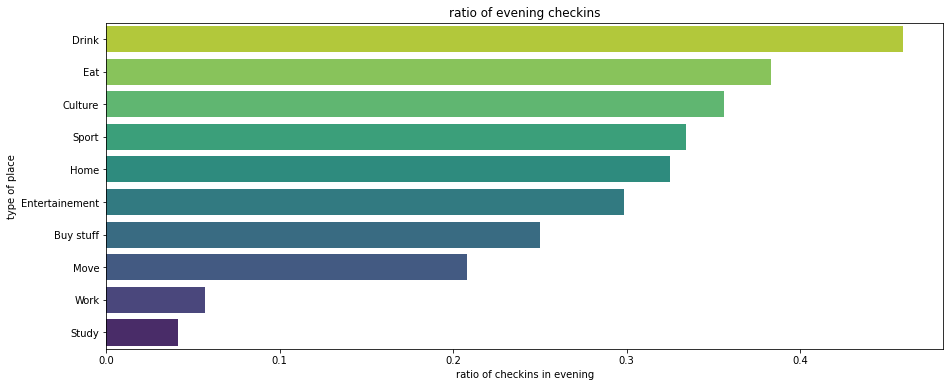

In [333]:
plt.figure(figsize=(15,6))
sns.barplot(x=df5['ratio evening'],y=df5['place_x'],orient='h', palette='viridis_r')
plt.xlabel('ratio of checkins in evening')
plt.ylabel('type of place')
plt.title('ratio of evening checkins')

In [ ]:
######Code To be cleaned and commented
###### interpertation of figures